In [40]:

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# from keras import regularizers
# from keras import optimizers

# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils import class_weight

# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import glob


In [49]:
batch_size = 32

def create_gender_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, input_shape=(150, 150, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])
    return model


    
gender_model = create_gender_model()                 

train_datagen = ImageDataGenerator(
#    rotation_range = 40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
#    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    'Data/train_gender',  
    target_size=(150, 150), 
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary')  


val_generator = val_datagen.flow_from_directory(
    'Data/val_gender',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary')

# callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
# ReduceLROnPlateau(patience=2), 
# ModelCheckpoint(filepath='gender_model_chk.h5', save_best_only=True)] 

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
gmodel = gender_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=6,
    validation_data=val_generator,
    validation_steps=STEP_SIZE_VALID
   )

# print out what each class means
print("class indices = " + str(train_generator.class_indices))

# save the model
gender_model.save_weights('gender_weights.h5')  # always save your weights after training or during training


Found 9699 images belonging to 2 classes.
Found 1209 images belonging to 2 classes.
Epoch 1/6
303/303 [==============================] - 491s 2s/step - loss: 0.6532 - binary_accuracy: 0.6211 - val_loss: 0.6041 - val_binary_accuracy: 0.6740
Epoch 2/6
303/303 [==============================] - 450s 1s/step - loss: 0.5540 - binary_accuracy: 0.7203 - val_loss: 0.5484 - val_binary_accuracy: 0.7221
Epoch 3/6
303/303 [==============================] - 459s 2s/step - loss: 0.5065 - binary_accuracy: 0.7549 - val_loss: 0.5034 - val_binary_accuracy: 0.7517
Epoch 4/6
303/303 [==============================] - 457s 2s/step - loss: 0.4629 - binary_accuracy: 0.7877 - val_loss: 0.4782 - val_binary_accuracy: 0.7762
Epoch 5/6
303/303 [==============================] - 456s 2s/step - loss: 0.4404 - binary_accuracy: 0.7978 - val_loss: 0.4667 - val_binary_accuracy: 0.7694
Epoch 6/6
303/303 [==============================] - 474s 2s/step - loss: 0.4176 - binary_accuracy: 0.8096 - val_loss: 0.4510 - val_bina

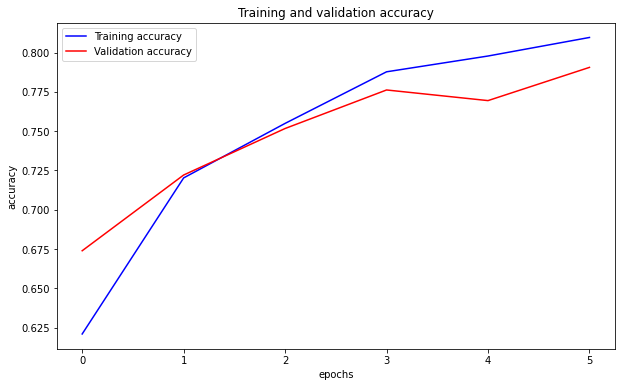

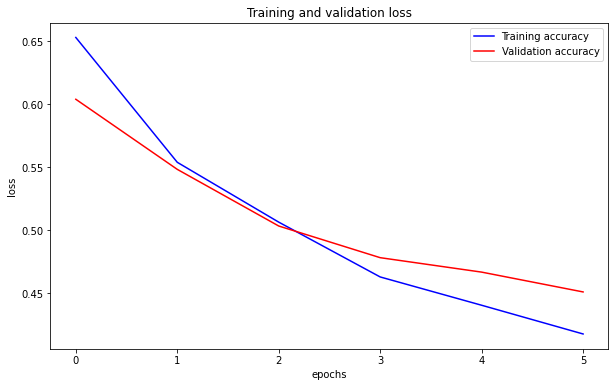

In [56]:

accuracy = gender_model.history.history['binary_accuracy']
val_accuracy = gender_model.history.history['val_binary_accuracy']
loss = gender_model.history.history['loss']
val_loss = gender_model.history.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,6)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()


In [57]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'Data/test_gender',
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=4,
    class_mode=None,
    shuffle=False,
#     seed=42
)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

# # model.evaluate_generator(generator=valid_generator,
# # steps=STEP_SIZE_VALID)

pred=gender_model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

gender_pred = [ (1 if y[0] > 0.5 else 0) for y in pred]
gender_desired = test_generator.classes

# # labels = (train_generator.class_indices)
# # labels = dict((v,k) for k,v in labels.items())
# # predictions = [labels[k] for k in y_pred]

filenames=test_generator.filenames

results=pd.DataFrame({"Filenames":filenames, "Desired Output": gender_desired, "Predicted Output": gender_pred})
results.to_csv("gender_prediction.txt",header= False, index= False, sep =' ')


Found 1204 images belonging to 2 classes.
301/301 [==============================] - 14s 47ms/step


In [59]:

accuracy = accuracy_score(gender_desired,gender_pred)   
print(accuracy *100)

male= 0
female =0
for i in range(len(gender_pred)):
    if y_pred[i]== 0:
        female+=1
    else:
        male+=1
print(male)
print(female)


78.07308970099668
605
599


In [36]:
# from sklearn.metrics import accuracy_score
# test_data = np.loadtxt('test_gender.txt', dtype=str)
# y_predict = test_data[:,1].astype('int')
# y_test = test_data[:,2].astype('int')

# accuracy = accuracy_score(y_test,y_predict)   
# print(accuracy *100)

In [60]:
batch_size = 64

def create_age_model():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, input_shape=(150, 150, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])
    return model
  
age_model = create_age_model()                 


train_agedatagen = ImageDataGenerator(
#    rotation_range = 40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
#    fill_mode='nearest')

val_agedatagen = ImageDataGenerator(rescale=1./255)


train_agegenerator = train_agedatagen.flow_from_directory(
    'Data/train_age',  
    target_size=(150, 150),  
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')  


val_agegenerator = val_agedatagen.flow_from_directory(
    'Data/val_age',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

#   callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
#   ReduceLROnPlateau(patience=2), 
#   ModelCheckpoint(filepath='gender_model_chk.h5', save_best_only=True)] 


STEP_SIZE_TRAIN=train_agegenerator.n//train_agegenerator.batch_size
STEP_SIZE_VALID=val_agegenerator.n//val_agegenerator.batch_size

amodel = age_model.fit(
    train_agegenerator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=6,
    validation_data=val_agegenerator,
    validation_steps=STEP_SIZE_VALID
   )

# print out what each class means
print("class indices = " + str(train_agegenerator.class_indices))

# save the model
age_model.save_weights('age_weights.h5')  # always save your weights after training or during training


Found 10136 images belonging to 8 classes.
Found 1038 images belonging to 8 classes.
Epoch 1/6
158/158 [==============================] - 775s 5s/step - loss: 2.0046 - categorical_accuracy: 0.2982 - val_loss: 1.8376 - val_categorical_accuracy: 0.3350
Epoch 2/6
158/158 [==============================] - 493s 3s/step - loss: 1.7006 - categorical_accuracy: 0.3873 - val_loss: 1.6475 - val_categorical_accuracy: 0.3525
Epoch 3/6
158/158 [==============================] - 467s 3s/step - loss: 1.5487 - categorical_accuracy: 0.4339 - val_loss: 1.5854 - val_categorical_accuracy: 0.3633
Epoch 4/6
158/158 [==============================] - 473s 3s/step - loss: 1.4636 - categorical_accuracy: 0.4543 - val_loss: 1.5563 - val_categorical_accuracy: 0.3730
Epoch 5/6
158/158 [==============================] - 492s 3s/step - loss: 1.3804 - categorical_accuracy: 0.4886 - val_loss: 1.5824 - val_categorical_accuracy: 0.3525
Epoch 6/6
158/158 [==============================] - 618s 4s/step - loss: 1.3287 - ca

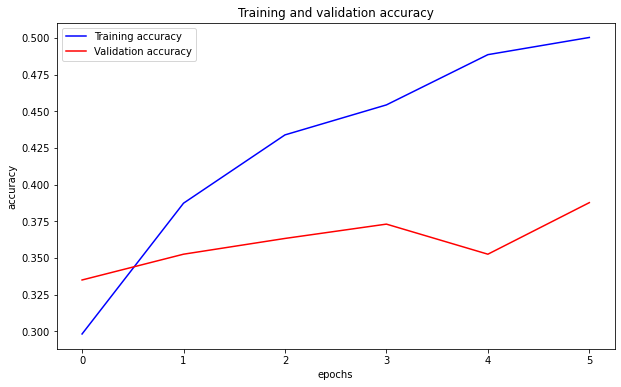

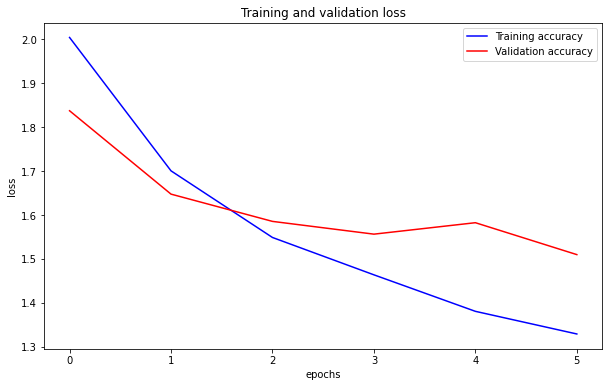

In [61]:

accuracy = age_model.history.history['categorical_accuracy']
val_accuracy = age_model.history.history['val_categorical_accuracy']
loss = age_model.history.history['loss']
val_loss = age_model.history.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,6)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()


In [91]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_agegenerator = test_datagen.flow_from_directory(
    'Data/test_age',
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=8,
    class_mode=None,
    shuffle=False,
#     seed=42
)

STEP_SIZE_TEST=test_agegenerator.n//test_agegenerator.batch_size

test_agegenerator.reset()

# # model.evaluate_generator(generator=valid_generator,
# # steps=STEP_SIZE_VALID)

predict=age_model.predict(test_agegenerator,
steps=STEP_SIZE_TEST,
verbose=1)


age_pred = np.argmax(predict, axis=1)
age_desired = test_agegenerator.classes

# # labels = (train_generator.class_indices)
# # labels = dict((v,k) for k,v in labels.items())
# # predictions = [labels[k] for k in y_pred]

filenames=test_agegenerator.filenames

results=pd.DataFrame({"Filenames":filenames,"Desired Output": age_desired, "Predicted Output": age_pred})
results.to_csv("age_prediction.txt",header= False, index= False, sep =' ')


Found 1008 images belonging to 8 classes.
126/126 [==============================] - 11s 84ms/step


In [92]:
age_accuracy = accuracy_score(age_desired,age_pred)   
print(age_accuracy *100)

# test_age = np.loadtxt('age_gender.txt', dtype=str)
# age_predict = test_age[:,1].astype('int')
# age_test = test_age[:,2].astype('int')

# accuracy = accuracy_score(age_test,age_predict)   
# print(accuracy *100)


43.551587301587304
